# C8Steerable CNN


In [1]:
try:
    done
except:
    import os

    os.chdir("../../../")
    from utils.download import download
    from utils.extract import extract

    args = {"model": "Model-1"}
    download(args)
    extract("data/Model_I.tgz", "data/")
    extract("data/Model_I_test.tgz", "data/")
    done = True

Downloading...
From (uriginal): https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV
From (redirected): https://drive.google.com/uc?id=1QMVLpqag6S9JWqzmGM_pK4C0F1eBVIfV&confirm=t&uuid=3024ff80-b04c-44f1-8b0d-b8d73757d0b1
To: /opt/repo/GSoC-23/data/Model_I.tgz
100%|█████████████████████████████████████████████████████| 1.99G/1.99G [00:24<00:00, 80.6MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1rUAKLLS3p9jDaL9R9m84JVKvMcUuVsO1
From (redirected): https://drive.google.com/uc?id=1rUAKLLS3p9jDaL9R9m84JVKvMcUuVsO1&confirm=t&uuid=92bb8eec-438a-4625-8611-7000a9f964ed
To: /opt/repo/GSoC-23/data/Model_I_test.tgz
100%|███████████████████████████████████████████████████████| 340M/340M [00:04<00:00, 82.6MB/s]


In [2]:
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from itertools import cycle
from PIL import Image
from sklearn.metrics import (
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
)
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


from tqdm import tqdm

warnings.filterwarnings("ignore")

# Data Preparation


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [4]:
class AxionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_name = "axion"
        self.class_folder = os.path.join(self.root_dir, self.class_name)
        self.file_list = [f for f in os.listdir(self.class_folder) if f.endswith('.npy')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.file_list[idx]
        file_path = os.path.join(self.class_folder, file_name)
        data = np.load(file_path, allow_pickle=True)
        image = data[0]
        weight = data[1]
        image = 255 * (image / image.max())
        image = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image.float(), weight.astype('float32')
    

trainset = AxionDataset(
    root_dir='data/Model_I',
    transform = train_transforms
)

testset = AxionDataset(
    root_dir='data/Model_I_test',
    transform = test_transforms
)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

In [5]:
lr = 0.0001
epochs = 30
gamma = 0.7
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model


In [6]:
class args: ...
args.batch_size = 64
args.std_mult = 0.7
args.filter_gain = 2
args.filter_size = 5
args.n_rings = 4
args.n_filters = 8 
args.dim = 128
args.n_classes = 1

In [7]:
from models import HN

model = HN(args).to(device)

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)

# Training


In [8]:
all_train_loss = []
all_test_loss = []


best_loss = np.inf

for epoch in range(epochs):
    epoch_loss = 0
    model.train()
    tr_loss_epoch = []
    test_loss_epoch = []
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label).float()
        tr_loss_epoch.append(loss.item())
       
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        epoch_loss += loss / len(train_loader)
    scheduler.step()
    all_train_loss.append(np.asarray(tr_loss_epoch))


    torch.cuda.empty_cache()
    with torch.no_grad():
        epoch_val_loss = 0
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)
            test_loss_epoch.append(val_loss.item())

            epoch_val_loss += val_loss.item() / len(test_loader)
        all_test_loss.append(np.asarray(test_loss_epoch))

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)

    print(
        f"Epoch : {epoch+1} - train loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f}%"
    )
torch.save(best_model.state_dict(), "equi_nn.pth")
all_train_loss_mean = [j.mean() for j in all_train_loss]
all_test_loss_mean = [j.mean() for j in all_test_loss]

100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.34it/s]


Epoch : 1 - train loss : 48.4790 - val_loss : 6.9611%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch : 2 - train loss : 4.7801 - val_loss : 2.8641%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch : 3 - train loss : 2.3208 - val_loss : 1.6556%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.42it/s]


Epoch : 4 - train loss : 1.4174 - val_loss : 1.0634%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch : 5 - train loss : 0.9377 - val_loss : 0.7195%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch : 6 - train loss : 0.6797 - val_loss : 0.5659%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.47it/s]


Epoch : 7 - train loss : 0.5233 - val_loss : 0.4300%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.40it/s]


Epoch : 8 - train loss : 0.3981 - val_loss : 0.3352%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch : 9 - train loss : 0.3009 - val_loss : 0.2373%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch : 10 - train loss : 0.2219 - val_loss : 0.1748%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch : 11 - train loss : 0.1665 - val_loss : 0.1352%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.32it/s]


Epoch : 12 - train loss : 0.1316 - val_loss : 0.1035%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch : 13 - train loss : 0.0995 - val_loss : 0.0772%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.48it/s]


Epoch : 14 - train loss : 0.0743 - val_loss : 0.0549%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.41it/s]


Epoch : 15 - train loss : 0.0536 - val_loss : 0.0416%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch : 16 - train loss : 0.0389 - val_loss : 0.0296%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.37it/s]


Epoch : 17 - train loss : 0.0293 - val_loss : 0.0210%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.40it/s]


Epoch : 18 - train loss : 0.0213 - val_loss : 0.0146%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch : 19 - train loss : 0.0153 - val_loss : 0.0101%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.39it/s]


Epoch : 20 - train loss : 0.0104 - val_loss : 0.0066%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.32it/s]


Epoch : 21 - train loss : 0.0072 - val_loss : 0.0041%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.38it/s]


Epoch : 22 - train loss : 0.0051 - val_loss : 0.0028%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.44it/s]


Epoch : 23 - train loss : 0.0037 - val_loss : 0.0020%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.43it/s]


Epoch : 24 - train loss : 0.0026 - val_loss : 0.0013%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.33it/s]


Epoch : 25 - train loss : 0.0019 - val_loss : 0.0006%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.36it/s]


Epoch : 26 - train loss : 0.0013 - val_loss : 0.0004%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.42it/s]


Epoch : 27 - train loss : 0.0011 - val_loss : 0.0003%


100%|██████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.21it/s]


Epoch : 28 - train loss : 0.0008 - val_loss : 0.0002%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.35it/s]


Epoch : 29 - train loss : 0.0052 - val_loss : 0.0002%


100%|██████████████████████████████████████████████████████████| 79/79 [00:14<00:00,  5.38it/s]

Epoch : 30 - train loss : 0.0005 - val_loss : 0.0001%


# Plotting Loss and Accuracy


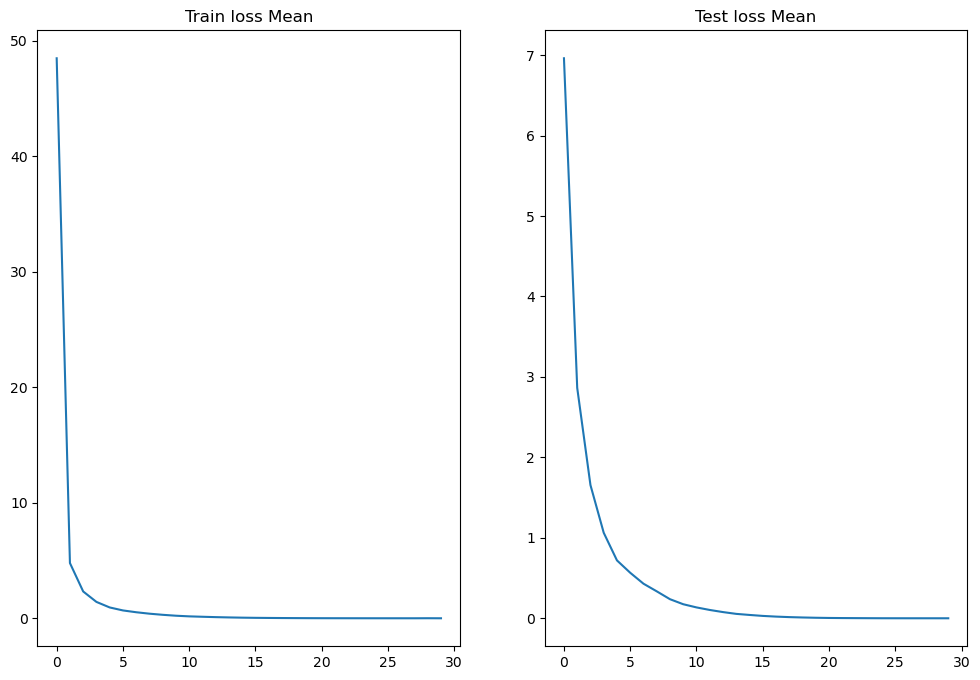

In [9]:
figure = plt.figure(figsize=(12, 8))
cols, rows = 2, 1
figure.add_subplot(rows, cols, 1)
plt.title("Train loss Mean")
plt.plot(all_train_loss_mean)
figure.add_subplot(rows, cols, 2)
plt.title("Test loss Mean")
plt.plot(all_test_loss_mean)

# Loading Best Model


In [10]:
model = HN(args).to(device)
model.load_state_dict(torch.load("equi_nn.pth"), strict=False)

<All keys matched successfully>

# Testing


In [11]:
import torch.nn.functional as F
with torch.no_grad():
    model.eval()
    rmse_list = []
    mse_list = []
    mae_list = []
    
    for i, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        y = y.to(device)
        _y = model(x)
        
        # Calculate metrics
        rmse = torch.sqrt(F.mse_loss(_y, y))
        mse = F.mse_loss(_y, y)
        mae = F.l1_loss(_y, y)
        
        rmse_list.append(rmse.item())
        mse_list.append(mse.item())
        mae_list.append(mae.item())

# Calculate overall metrics
avg_rmse = np.mean(rmse_list)
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)

print("Average RMSE:", avg_rmse)
print("Average MSE:", avg_mse)
print("Average MAE:", avg_mae)

100%|██████████████████████████████████████████████████████████| 79/79 [00:12<00:00,  6.49it/s]

Average RMSE: 0.011929277601781526
Average MSE: 0.00014381265701339993
Average MAE: 0.009442507289350033
